# House prices

Load needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr

sns.set(style='darkgrid', context='notebook', palette='deep')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Load datasets train and test

In [2]:
trainfull = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

Check datasets size

In [3]:
print(f"Trainfull data size before drop Id column : {trainfull.shape}")
print(f"Test data size before drop Id column : {test.shape}")

Trainfull data size before drop Id column : (1460, 81)
Test data size before drop Id column : (1459, 80)


We save the Id column and drop it from trainfull and test because it's useless for the process

In [4]:
trainfull_id = trainfull['Id']
test_id = test['Id']

In [5]:
trainfull.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

Check datasets size after drop Id values

In [6]:
print(f"Trainfull data size after drop Id column : {trainfull.shape}")
print(f"Test data size after drop Id column : {test.shape}")

Trainfull data size after drop Id column : (1460, 80)
Test data size after drop Id column : (1459, 79)


In [7]:
trainfull.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Analyze target "SalePrice"

In [9]:
trainfull['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We can see that the mean value is around 180 000 USD and we can say with standard deviation : 100 000 USD < 68% of the data < 260 000 USD

Visualization

Text(0.5, 1.0, 'SalePrice distribution')

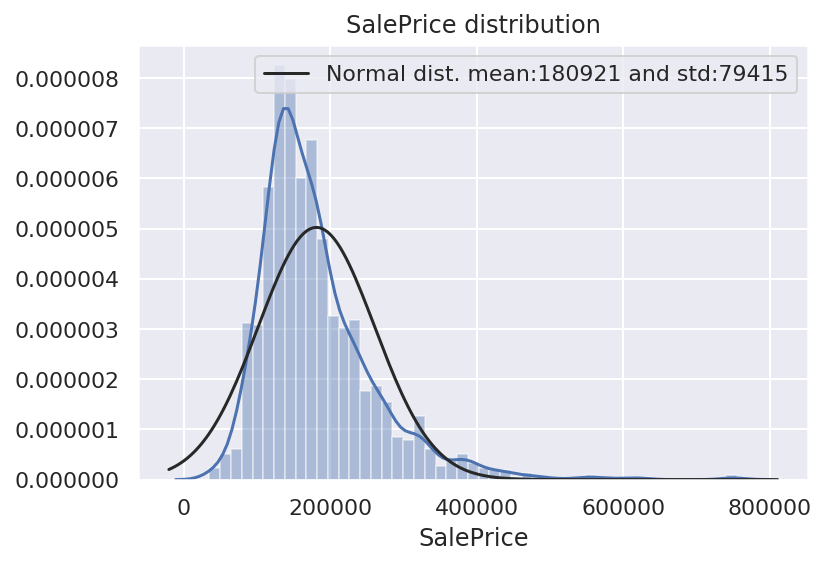

In [10]:
sns.distplot(trainfull['SalePrice'], fit = norm)
(mean, std) = norm.fit(trainfull['SalePrice'])
plt.legend([f"Normal dist. mean:{int(mean)} and std:{int(std)}"])
plt.title('SalePrice distribution')

In [11]:
skew_train = trainfull['SalePrice'].skew()
kurt_train = trainfull['SalePrice'].kurt()

print(f"SalePrice Skewness: {skew_train}")
print(f"SalePrice Kurtosis: {kurt_train}")

SalePrice Skewness: 1.8828757597682129
SalePrice Kurtosis: 6.536281860064529


The skewness and the kurtosis show that the sale prices deviate from the normal distribution and that there is a peak.  
We want our data to be as normal as possible so we will try to fix this.

We use log method from numpy to fix SalePrice skewness to have a more normal distribution

In [12]:
y_train_log = np.log(trainfull['SalePrice'])

Vizualisation of the normal distribution of SalePrice

Text(0.5, 1.0, 'SalePrice distribution')

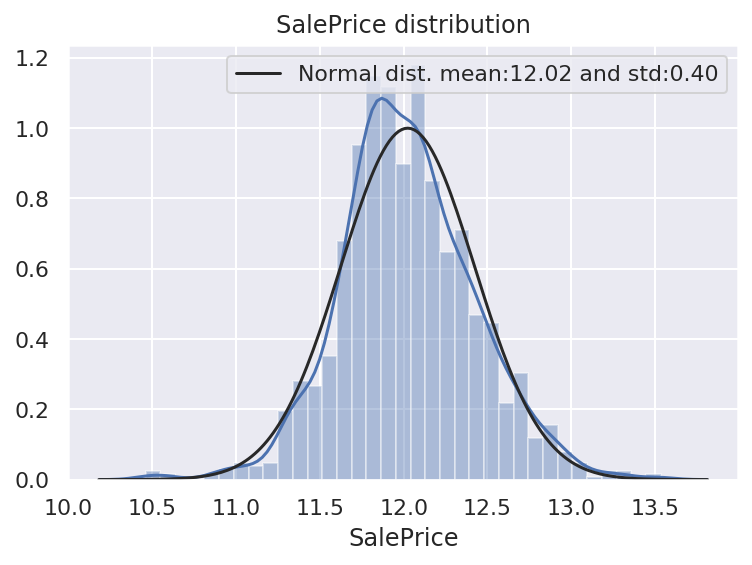

In [13]:
sns.distplot(y_train_log , fit=norm)
(mean, std) = norm.fit(y_train_log)
plt.legend([f"Normal dist. mean:{mean:.2f} and std:{std:.2f}"])
plt.title('SalePrice distribution')

In [14]:
skew_y_train_log = pd.DataFrame(y_train_log).skew()
kurt_y_train_log = pd.DataFrame(y_train_log).kurt()

print(f"SalePrice Skewness: {skew_train}")
print(f"SalePrice Kurtosis: {kurt_train}\n")

print(f"SalePrice_log Skewness: {skew_y_train_log.iloc[0]}")
print(f"SalePrice_log Kurtosis: {kurt_y_train_log.iloc[0]}")

SalePrice Skewness: 1.8828757597682129
SalePrice Kurtosis: 6.536281860064529

SalePrice_log Skewness: 0.12133506220520406
SalePrice_log Kurtosis: 0.8095319958036296


## Mutivariable analysis

We will split all features in two types :  
* Categorical
* Numerical

In [15]:
# Check categorical features
trainfull.select_dtypes(include = ['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [16]:
# Check numerical features
trainfull.select_dtypes(include = ['int64', 'float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [17]:
# Count features by type
total_cat = len(trainfull.select_dtypes(include = ['object']).columns)
total_num = len(trainfull.select_dtypes(include = ['int64', 'float64']).columns)

print(f"{total_cat} categorical + {total_num} numerical = {total_cat + total_num} features")

43 categorical + 37 numerical = 80 features


### Correlation matrix heatmap

In [18]:
corrmat = trainfull.corr()

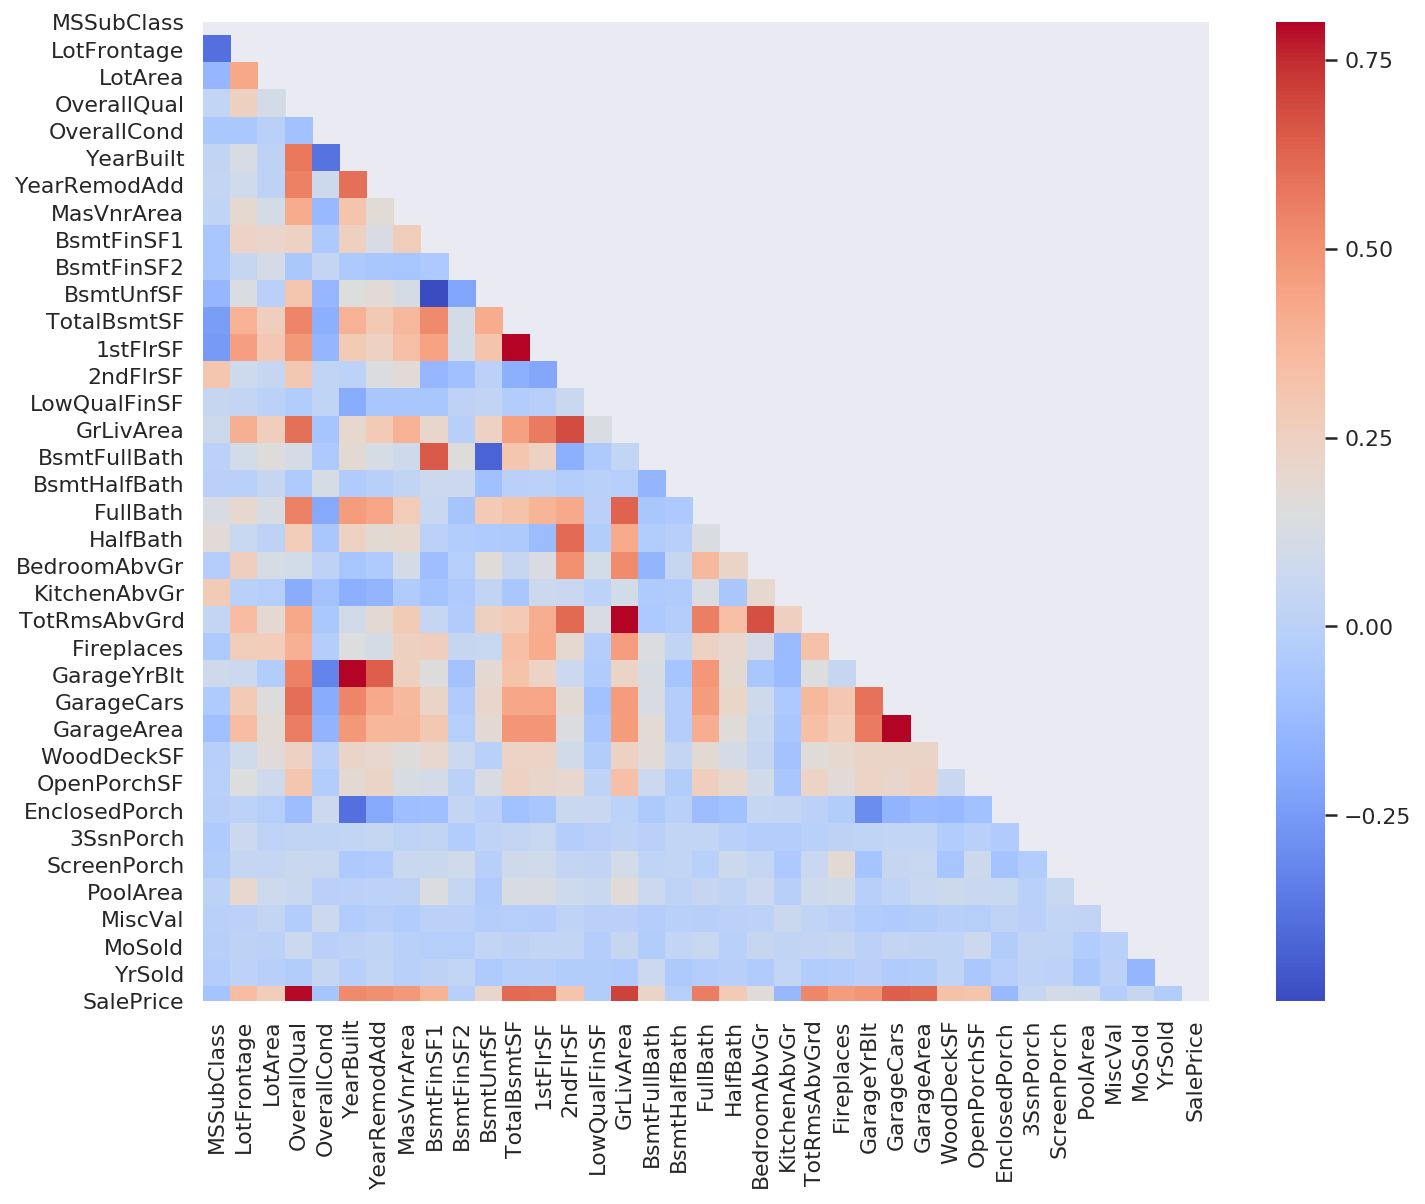

In [19]:
f, ax = plt.subplots(figsize = (12, 9))
mask = np.zeros_like(corrmat)           # to display only
mask[np.triu_indices_from(mask)] = True # half of the matrix
sns.heatmap(corrmat,mask=mask, vmax = .8, square = True, cmap = "coolwarm")

### Top 10 variables related to SalePrice

Another Correlation Matrix with Top 10  features most related to Sale Price  
We select the 11 most correlated features to SalePrice because there will be SalePrice in the list, so we will consider the 10 others. 

In [20]:
k = 11
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

In [21]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')

In [22]:
# Display correlation coeff
top_10_corrmat = trainfull[cols].corr()

In [23]:
top_10_corrmat

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
SalePrice,1.000000,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897,0.507101
OverallQual,0.790982,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.427452,0.572323,0.550684
GrLivArea,0.708624,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.825489,0.199010,0.287389
GarageCars,0.640409,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.362289,0.537850,0.420622
GarageArea,0.623431,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.337822,0.478954,0.371600
TotalBsmtSF,0.613581,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.285573,0.391452,0.291066
1stFlrSF,0.605852,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.409516,0.281986,0.240379
FullBath,0.560664,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.554784,0.468271,0.439046
TotRmsAbvGrd,0.533723,0.427452,0.825489,0.362289,0.337822,0.285573,0.409516,0.554784,1.000000,0.095589,0.191740
YearBuilt,0.522897,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,0.095589,1.000000,0.592855


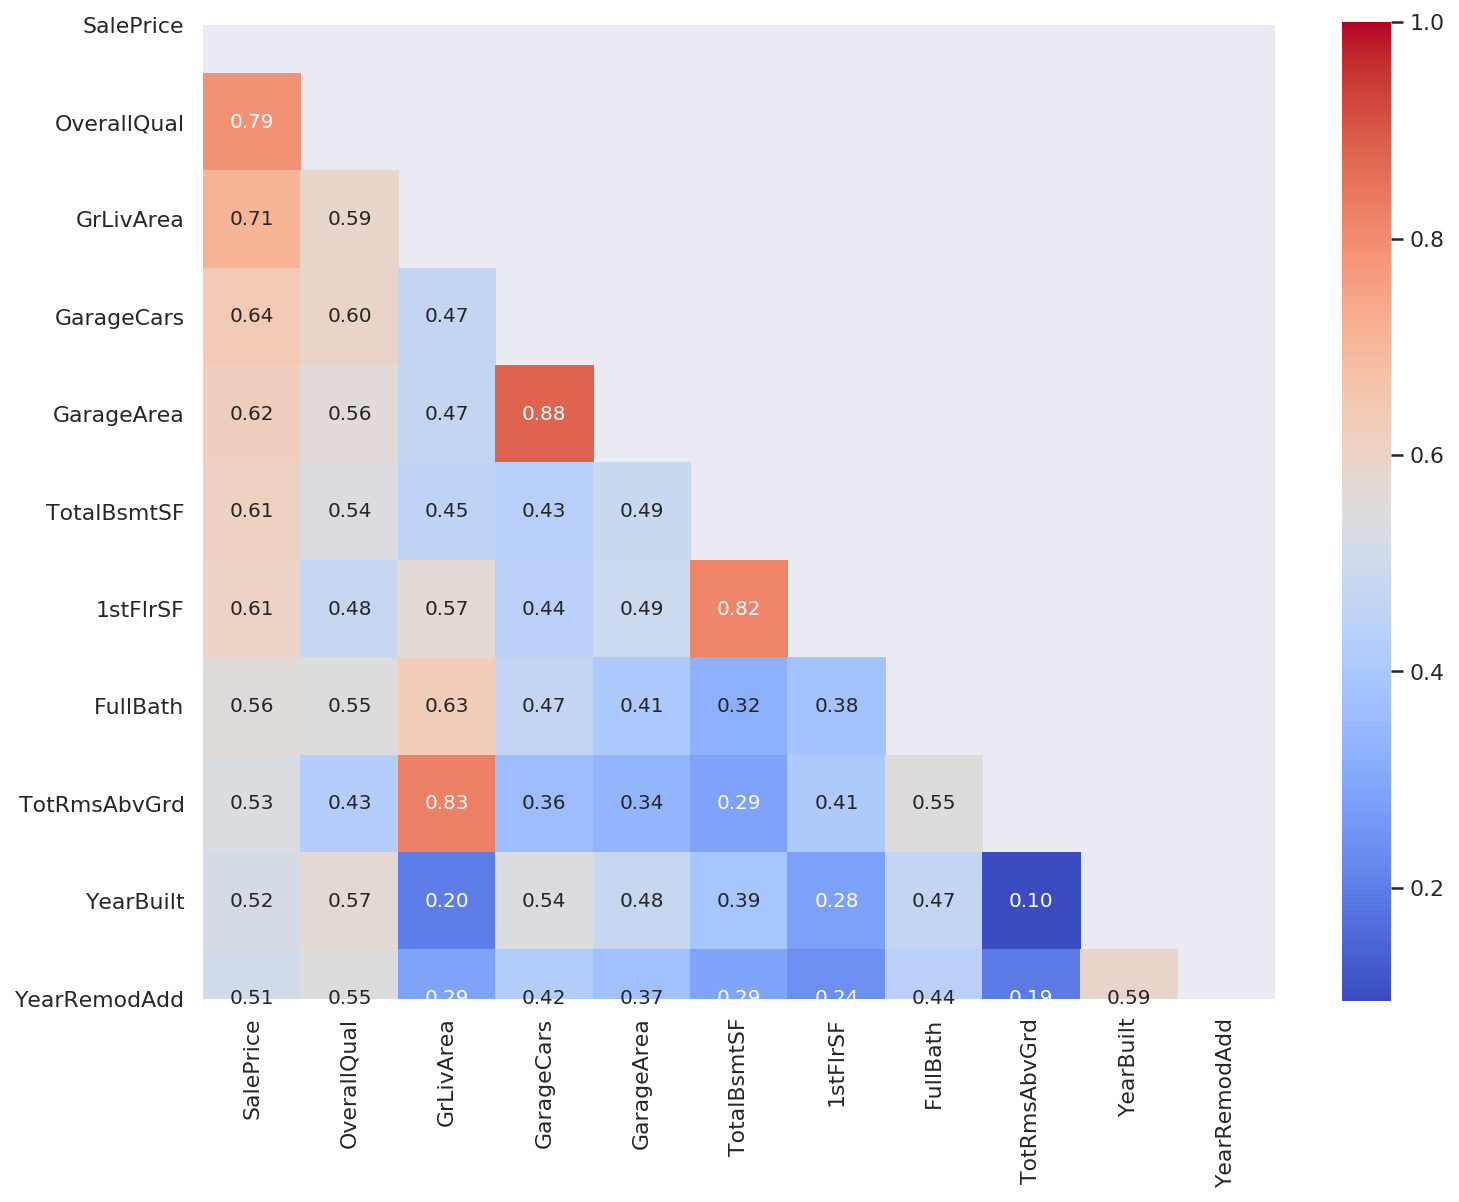

In [24]:
f, ax = plt.subplots(figsize = (12, 9))
mask = np.zeros_like(top_10_corrmat)           # to display only
mask[np.triu_indices_from(mask)] = True # half of the matrix
top_10_heatmap = sns.heatmap(top_10_corrmat, 
                             annot = True, 
                             square = True, 
                             fmt = '.2f', 
                             annot_kws = {'size': 10},
                             yticklabels = cols.values,
                             xticklabels = cols.values,
                             mask = mask,
                             cmap = "coolwarm"
                            )

We create a dataframe of top 10 features most correlated to Sale Price

In [25]:
df = top_10_corrmat.iloc[1:,:1]

In [26]:
df = df.rename(columns={'SalePrice':'corrCoeffSalePrice'})
df

,corrCoeffSalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's compare each most correlated features with Sale Price

For integer type features we will use boxplot  
For float type features we will use scatterplot with linear reg

#### OverallQual

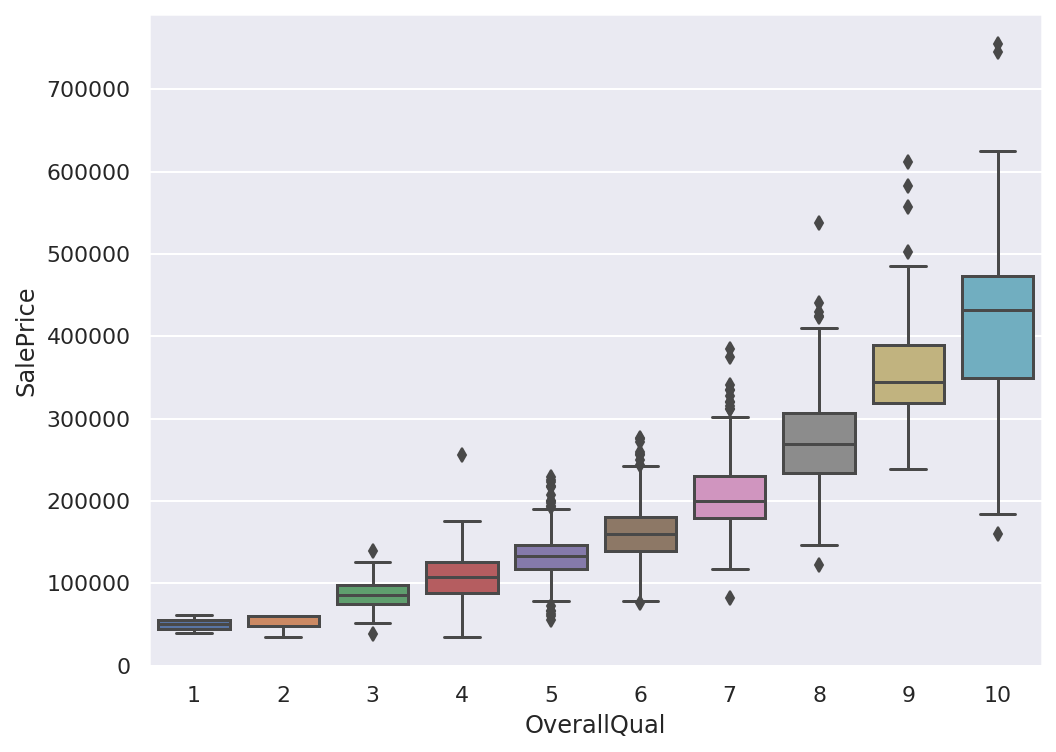

In [27]:
#Boxplot
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = trainfull)
#fig.axis(ymax=800000)

#### GrLivArea

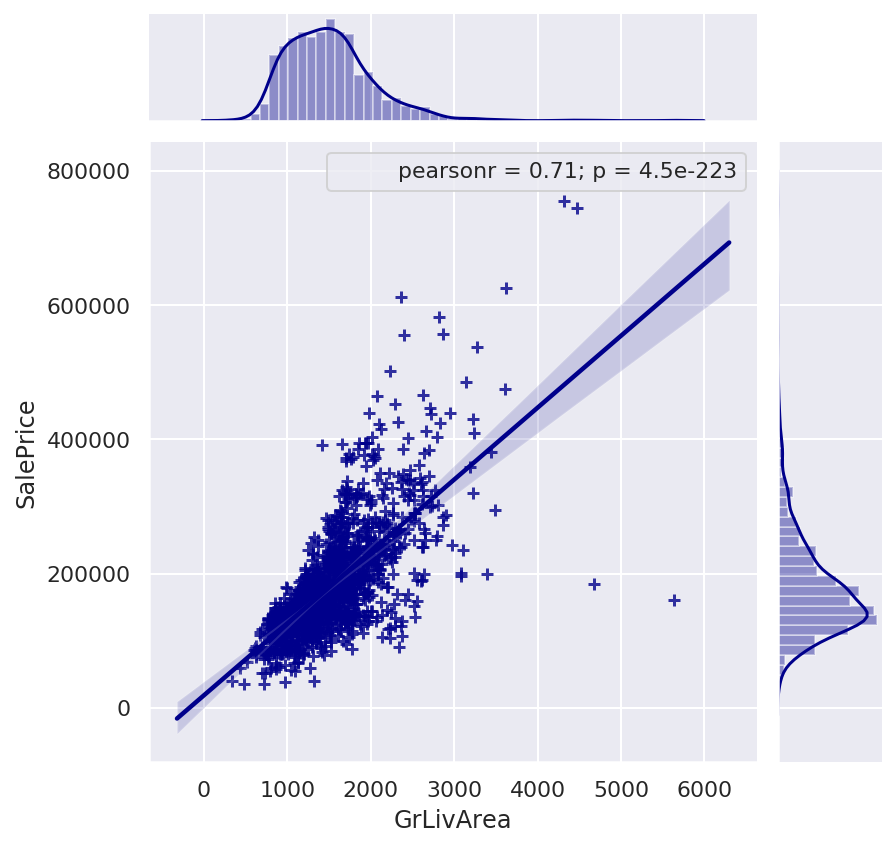

In [28]:
sns.jointplot(x = trainfull['GrLivArea'], 
              y = trainfull['SalePrice'], 
              kind = 'reg',
              marker = "+", 
              color = "darkblue").annotate(pearsonr)

We can observe that for a larger GrLivArea the Sale Price increase which seems logical.  
We also see two outliers where the GrLivArea is very large but the price is low.  
Let's try to remove those two values.

In [29]:
# Remove outliers (two points where GrLivArea > 4000 and SalePrice < 200 000)
trainfull = trainfull.drop(trainfull[(trainfull['GrLivArea'] > 4000) & (trainfull['SalePrice'] < 200000)].index).reset_index(drop=True)

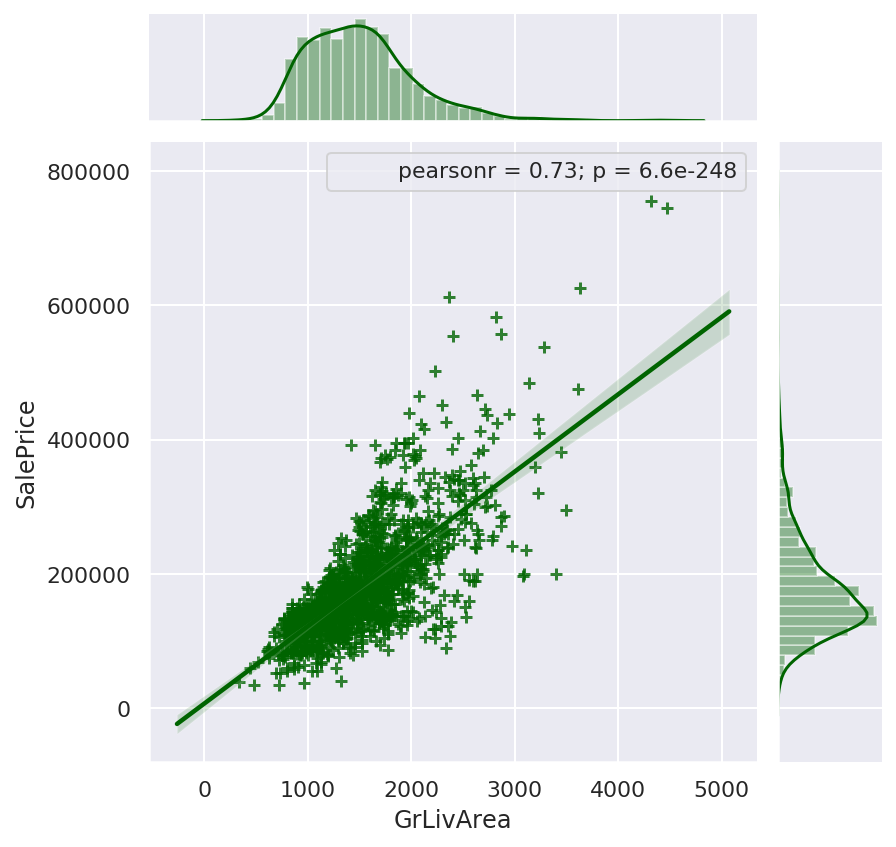

In [30]:
sns.jointplot(x = trainfull['GrLivArea'], 
              y = trainfull['SalePrice'], 
              kind = 'reg',
              marker = "+", 
              color = "darkgreen").annotate(pearsonr)

The correlation coefficient increases by 0.02 after removing outliers values

#### GarageCars 

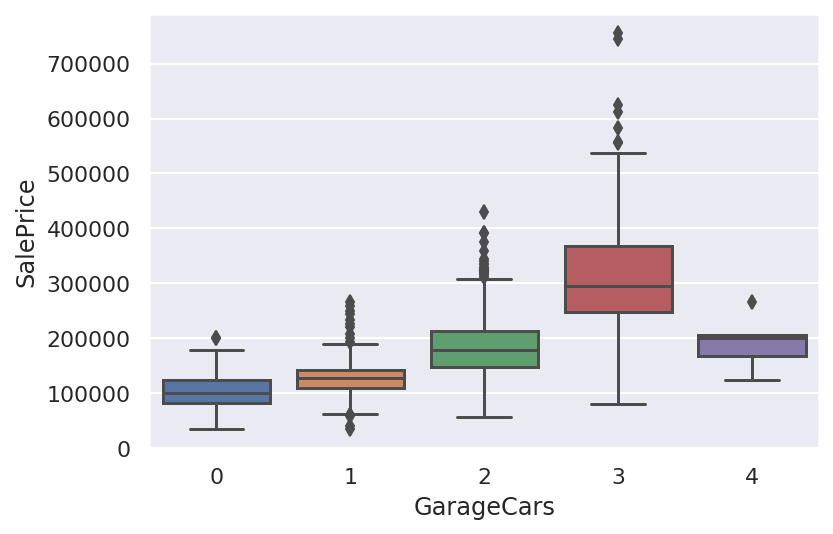

In [31]:
sns.boxplot(x = trainfull['GarageCars'], y = trainfull['SalePrice'])

We can observe the more cars you can park in your garage, the more the Sale Price is high.
After more than 3 places available in the garage, the Sale Price decrease which is not logical. So we will remove the outlier values were garageCars > 3 and SalePrice < 300 000

In [32]:
# Remove outliers (where GarageCars > 3 and SalePrice < 300 000)
trainfull = trainfull.drop(trainfull[(trainfull['GarageCars'] > 3) & (trainfull['SalePrice'] < 300000)].index).reset_index(drop=True)

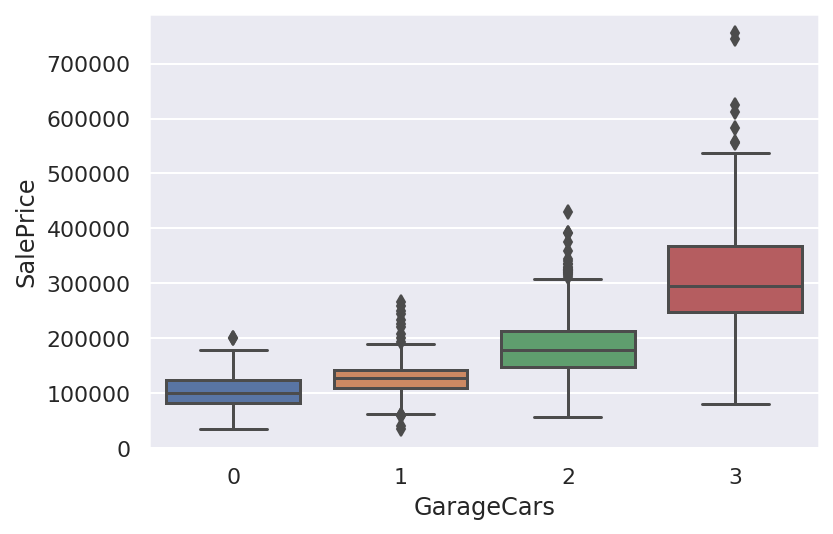

In [33]:
sns.boxplot(x = trainfull['GarageCars'], y = trainfull['SalePrice'])

#### GarageArea 

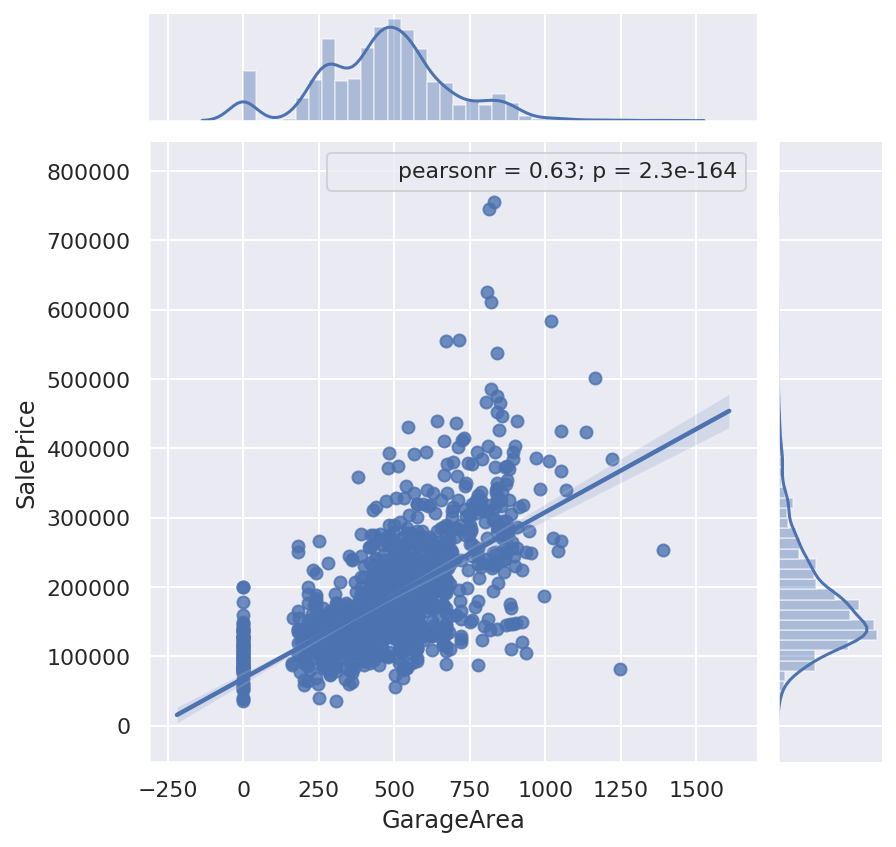

In [34]:
sns.jointplot(x=trainfull['GarageArea'], y = trainfull['SalePrice'], kind='reg').annotate(pearsonr)

Two outliers (GarageArea > 1200 and SalePrice < 300000)  
Let's remove this

In [35]:
trainfull = trainfull.drop(trainfull[(trainfull['GarageArea'] > 1200) & (trainfull['SalePrice'] < 300000)].index).reset_index(drop=True)

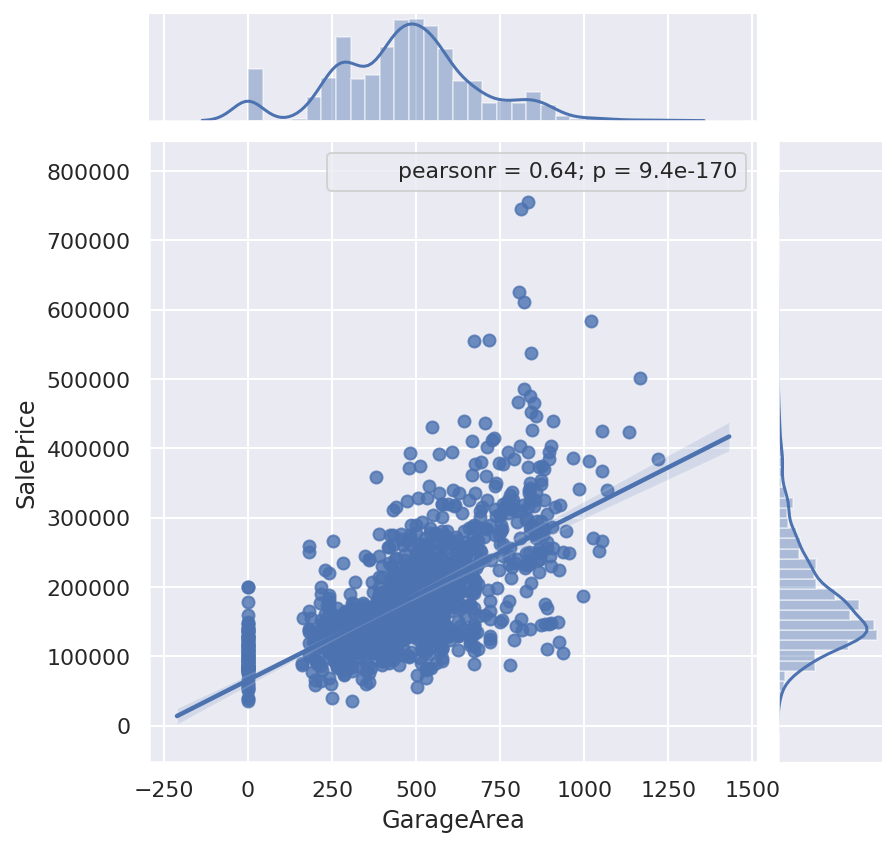

In [36]:
sns.jointplot(x=trainfull['GarageArea'], y = trainfull['SalePrice'], kind='reg').annotate(pearsonr)

We increase the correlation coefficient by 0.01 point

#### TotalBsmtSF

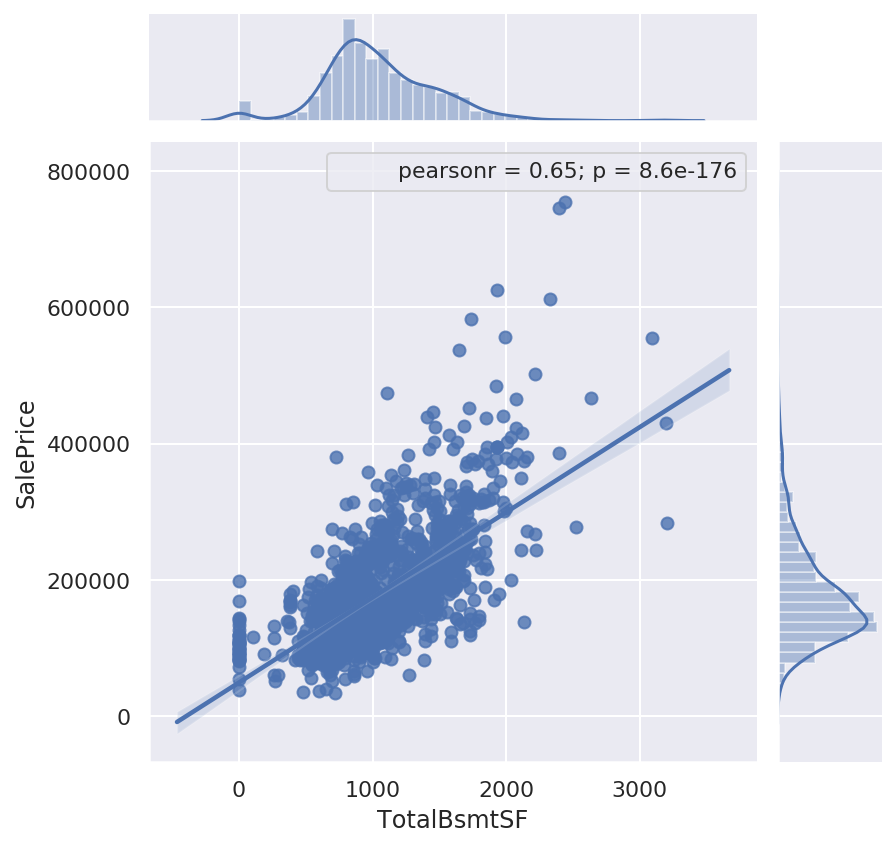

In [37]:
sns.jointplot(x=trainfull['TotalBsmtSF'], y = trainfull['SalePrice'], kind='reg').annotate(pearsonr)

We don't see any obvious outlier value here

#### 1stFlrSF

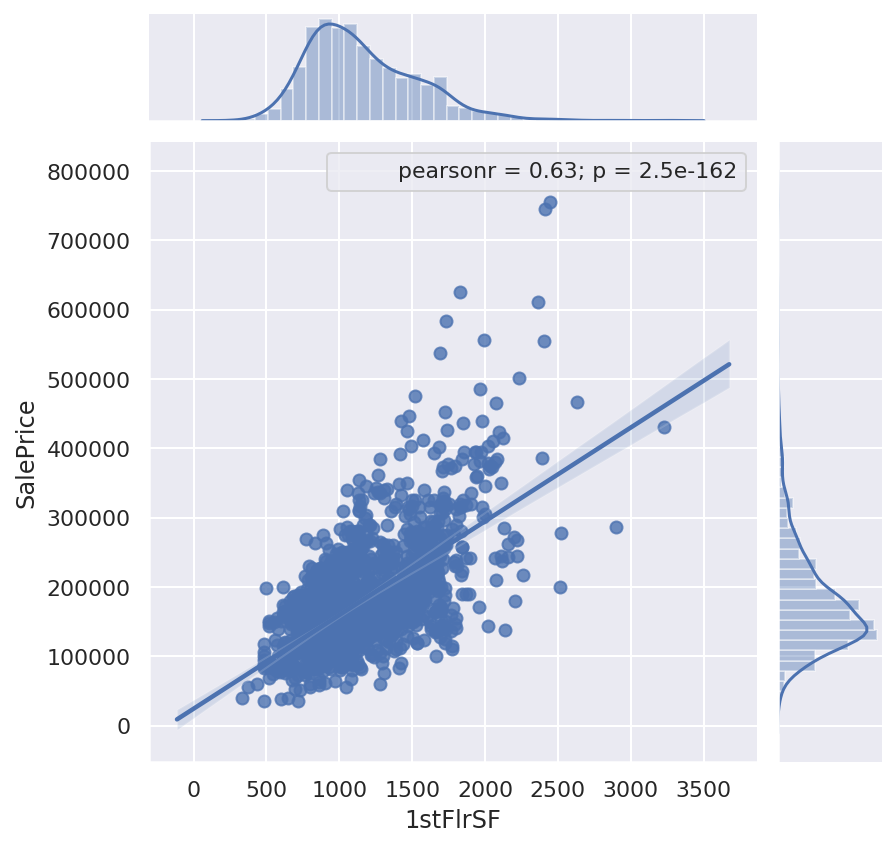

In [38]:
sns.jointplot(x=trainfull['1stFlrSF'], y = trainfull['SalePrice'], kind='reg').annotate(pearsonr)

Nothing here

#### FullBath

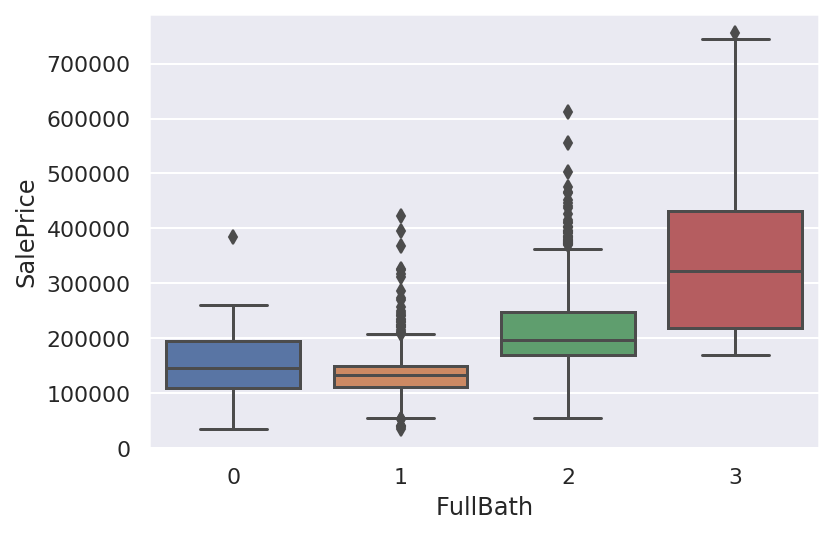

In [39]:
sns.boxplot(x = trainfull['FullBath'], y = trainfull['SalePrice'])

#### TotRmsAbvGrd

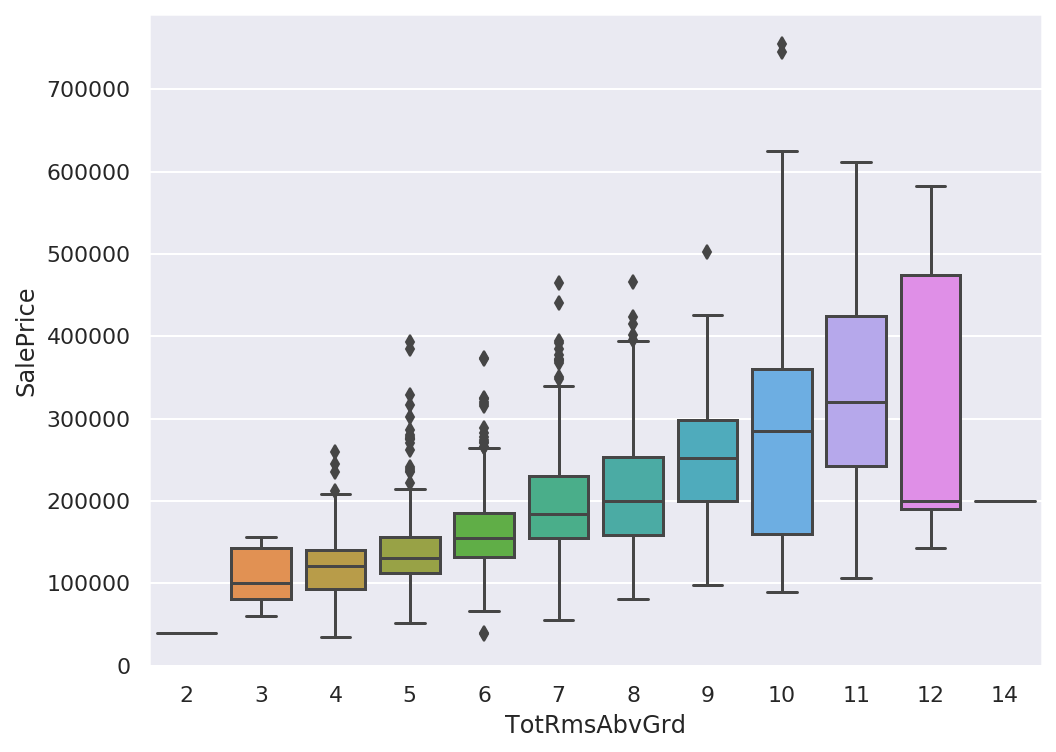

In [40]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = trainfull['TotRmsAbvGrd'], y = trainfull['SalePrice'])

We can observe houses with more than 11 rooms are less expensive.  
It could be a price reduction offered by the real estate agent or an outlier.  
We will consider this as an outlier and remove those values.

In [41]:
trainfull = trainfull.drop(trainfull[(trainfull['TotRmsAbvGrd'] > 11) & (trainfull['SalePrice'] < 300000)].index).reset_index(drop=True)

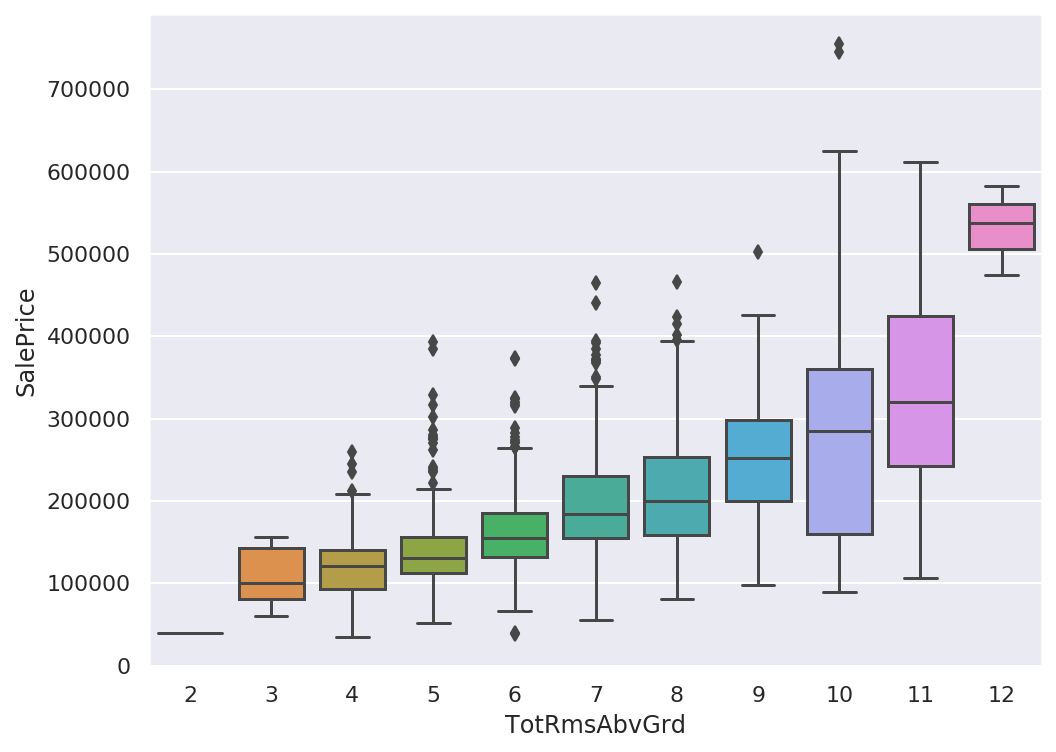

In [42]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = trainfull['TotRmsAbvGrd'], y = trainfull['SalePrice'])

#### YearBuilt

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

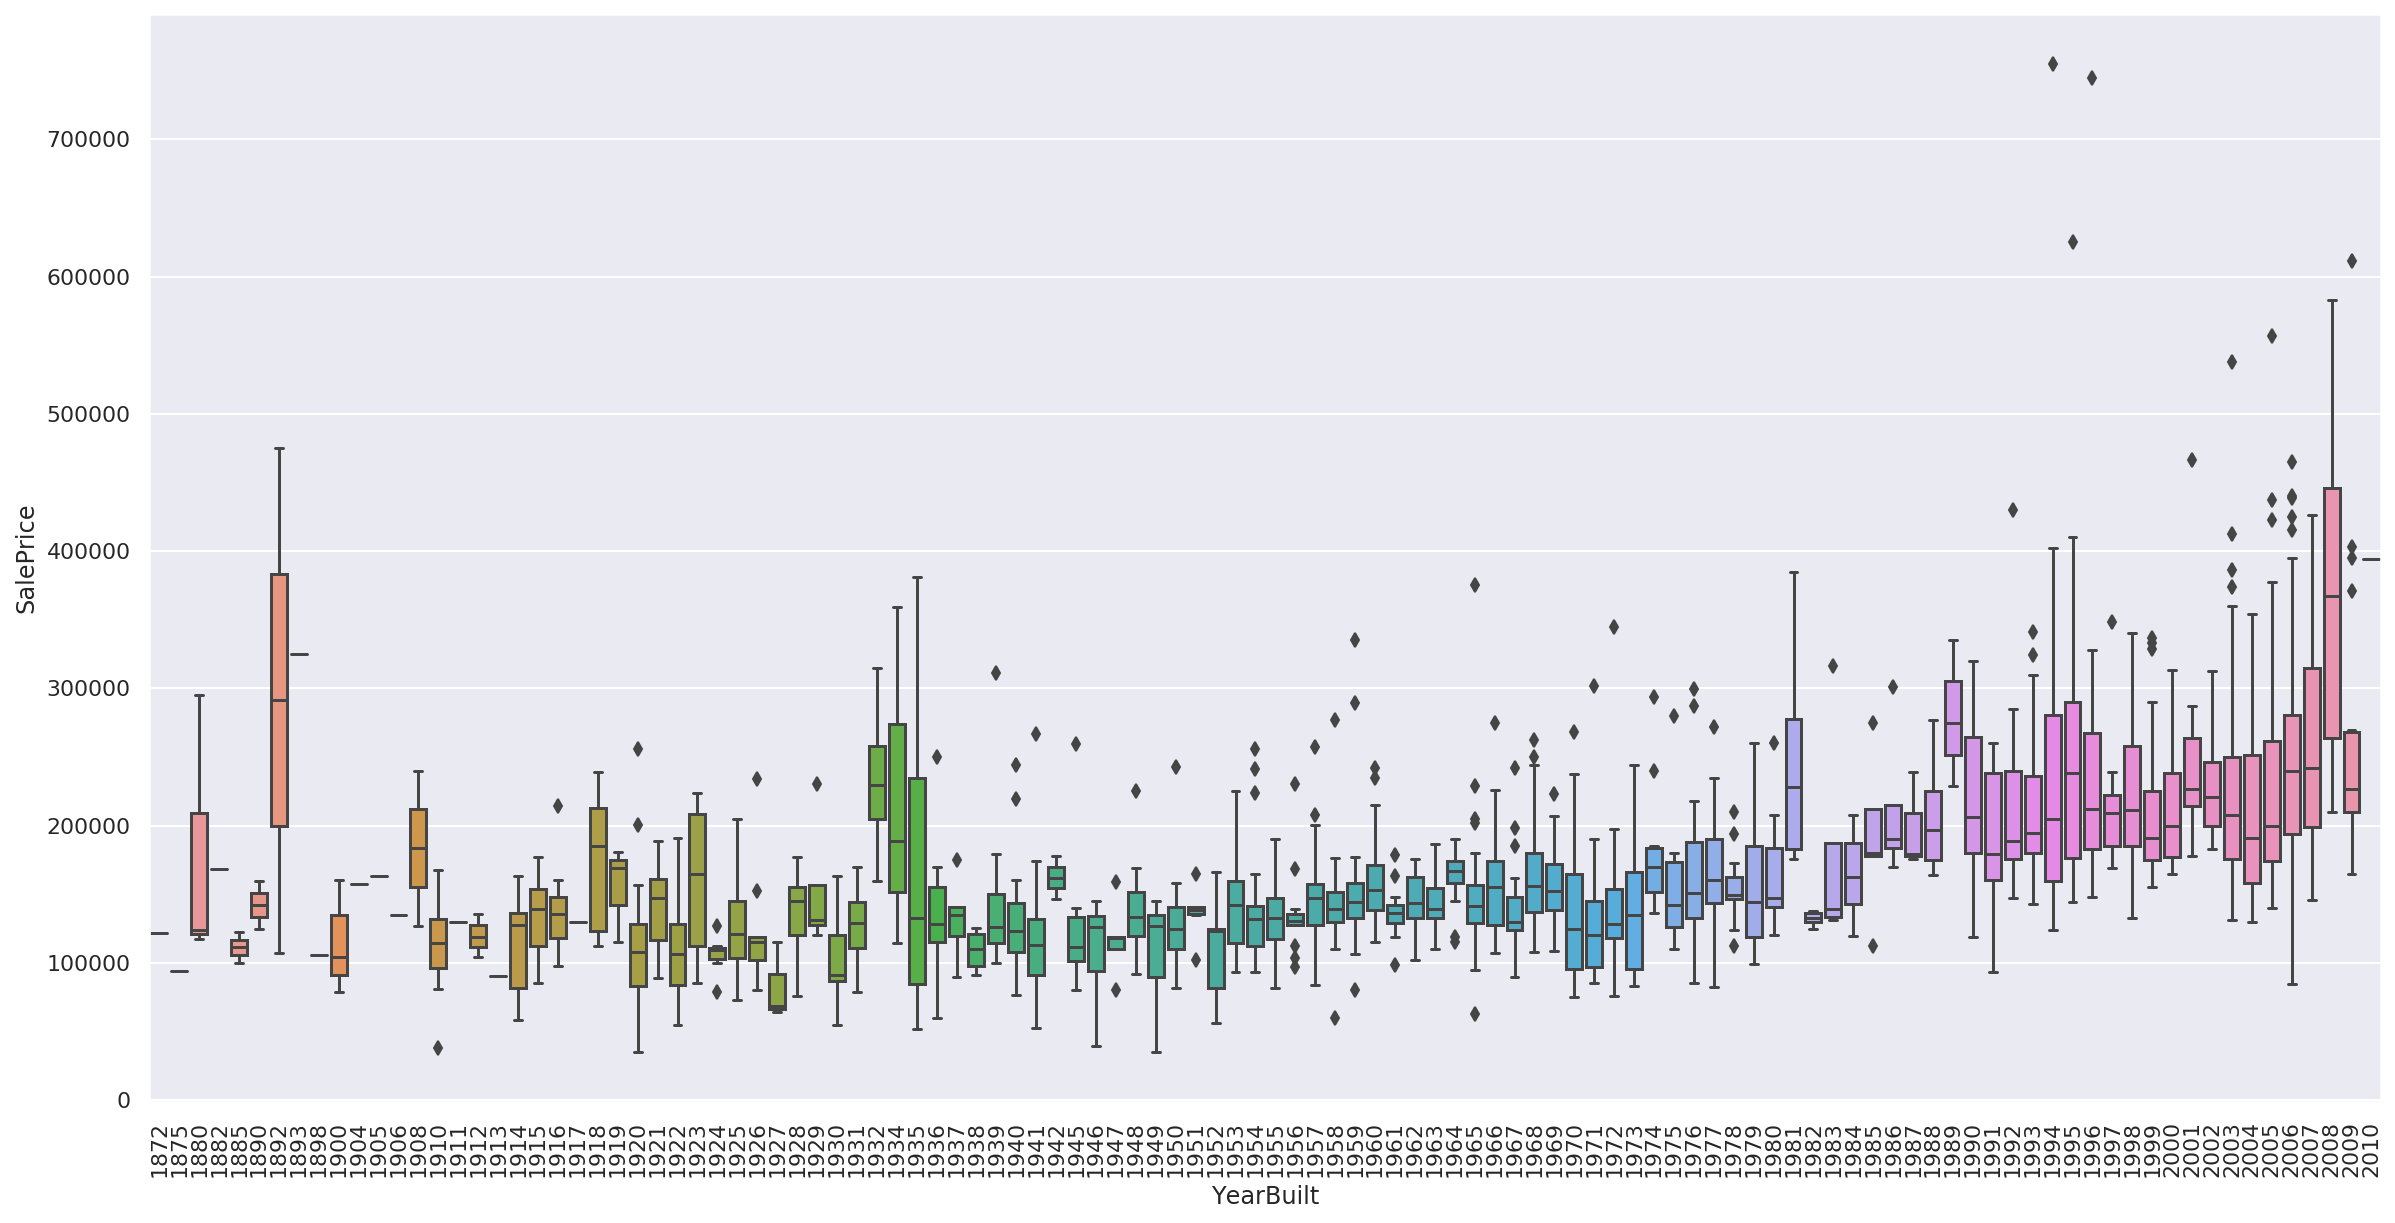

In [43]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x = trainfull['YearBuilt'], y = trainfull['SalePrice'])
plt.xticks(rotation = 90)

We cannot be sure if the High Sale Prices are a consequence of the inflation or crisis (1929, 1973, 2008) so we don't change anything here. 

#### YearRemodAdd

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text xticklabel objects>)

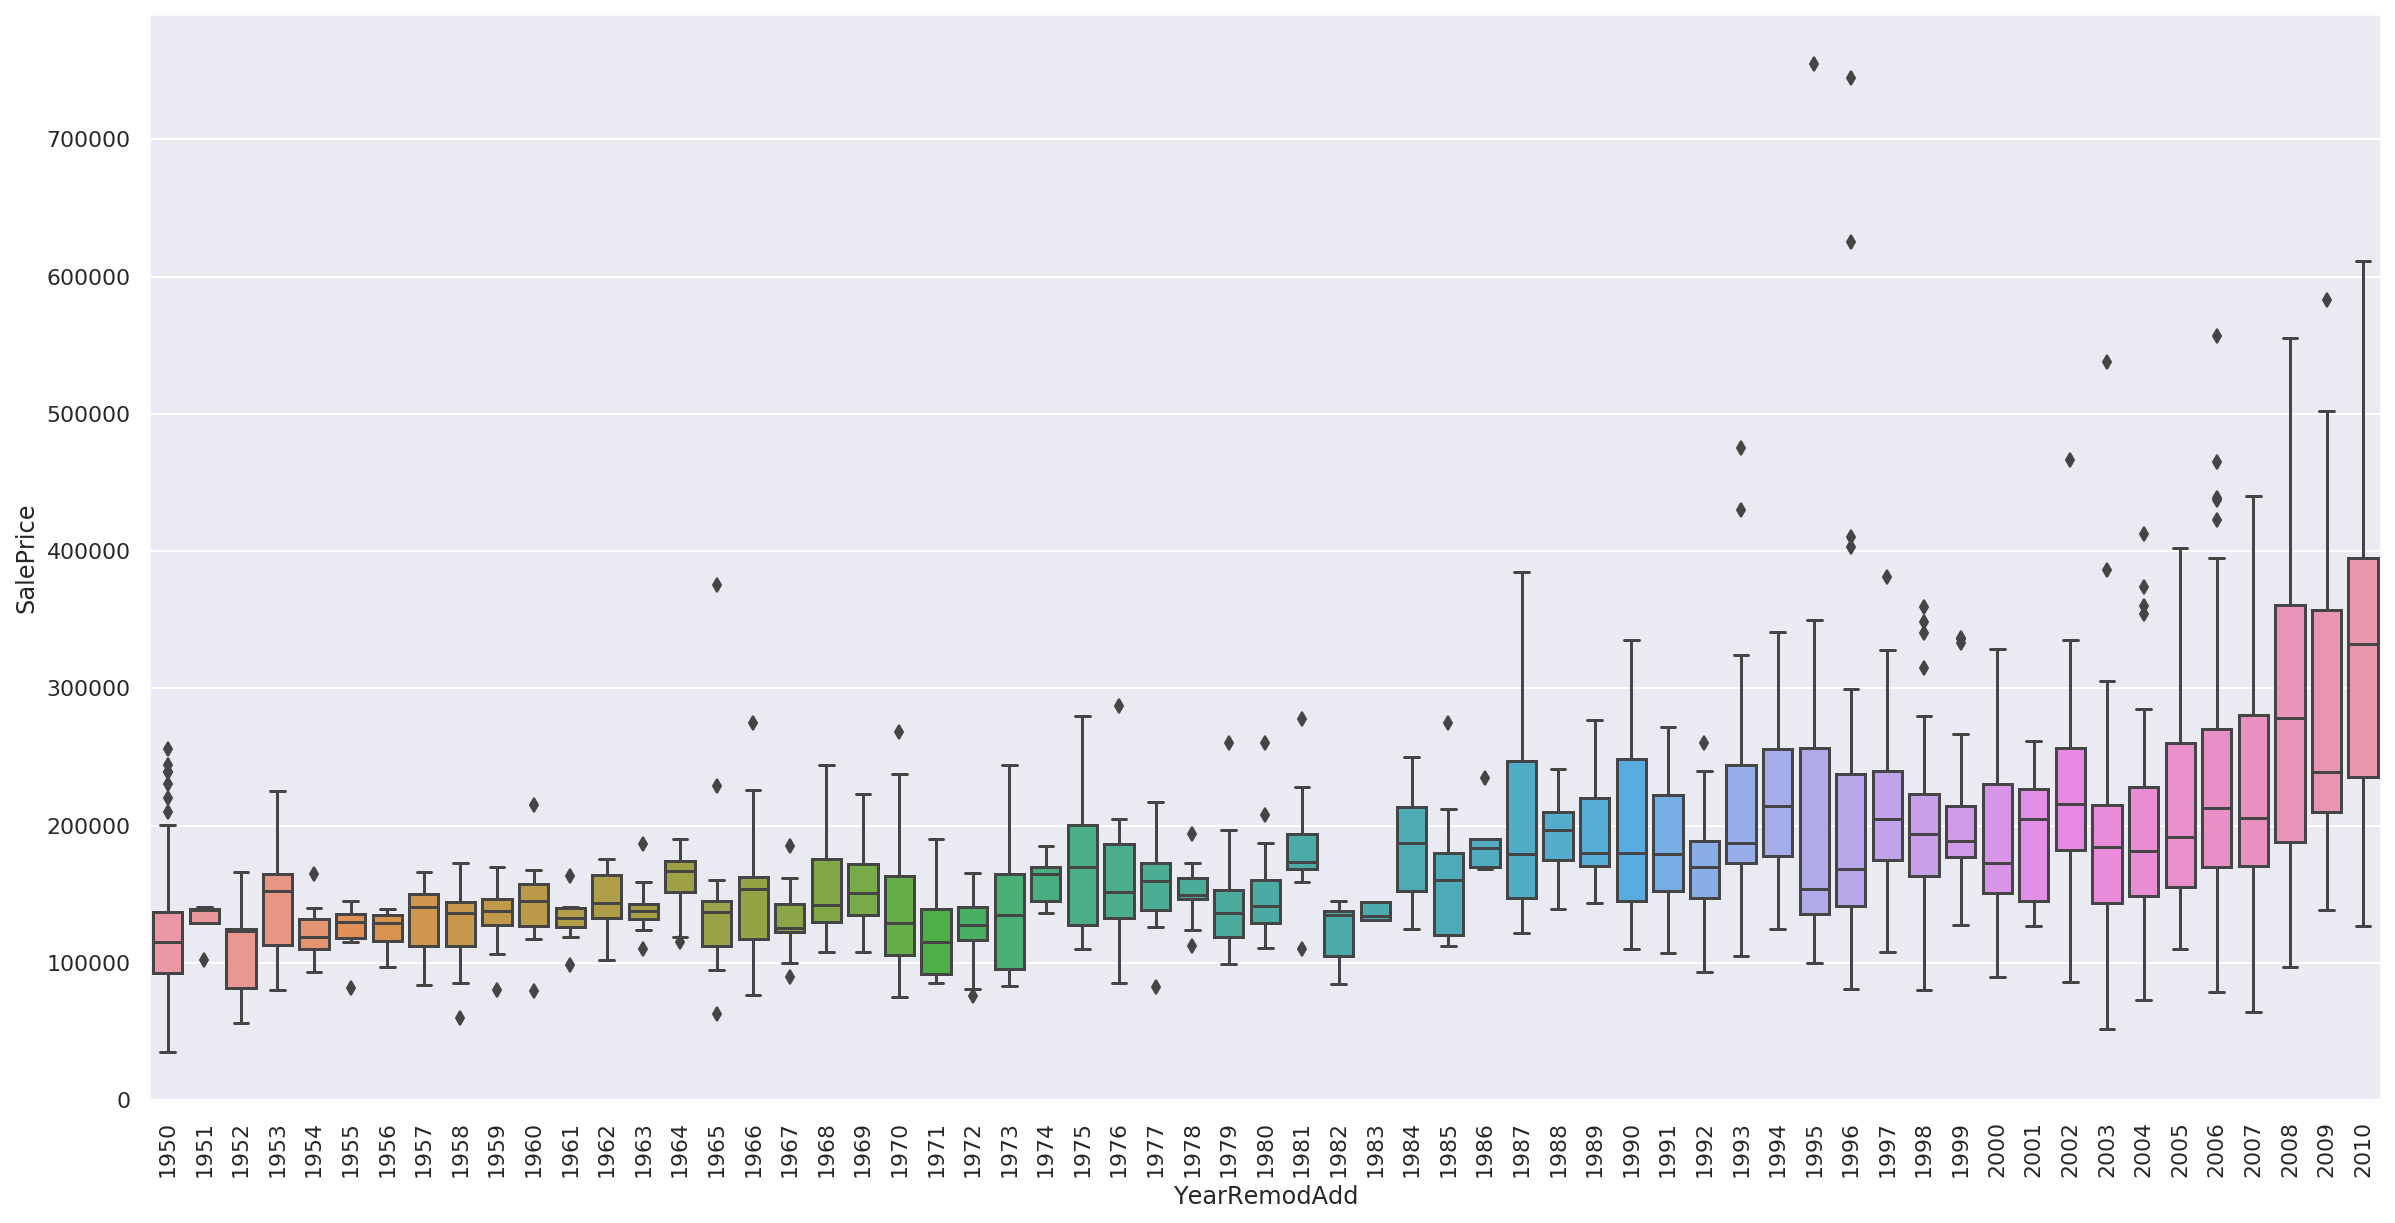

In [44]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x = trainfull['YearRemodAdd'], y = trainfull['SalePrice'])
plt.xticks(rotation = 90)

## Missing Data

### Analyse Missing Data

Missing values ratio

In [45]:
trainfull_na = (trainfull.isnull().sum() / len(trainfull)) * 100
trainfull_na = trainfull_na.drop(trainfull_na[trainfull_na == 0].index).sort_values(ascending = False)

In [46]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending = False)

In [47]:
print(f"Number of missing values in trainfull: {len(trainfull_na)}")
print(f"Number of missing values in test: {len(test_na)}")

Number of missing values in trainfull: 19
Number of missing values in test: 33


In [48]:
missing_data_trainfull = pd.DataFrame({'Missing Values Ratio Train' :trainfull_na})
missing_data_trainfull

,Missing Values Ratio Train
PoolQC,99.653740
MiscFeature,96.468144
Alley,93.836565
Fence,80.747922
FireplaceQu,47.299169
LotFrontage,17.797784
GarageYrBlt,5.470914
GarageType,5.470914
GarageFinish,5.470914
GarageQual,5.470914


In [49]:
missing_data_test = pd.DataFrame({'Missing Values Ratio Train' :test_na})
missing_data_test

,Missing Values Ratio Train
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270
LotFrontage,15.558602
GarageYrBlt,5.346127
GarageCond,5.346127
GarageQual,5.346127
GarageFinish,5.346127


Vizualisation Missing Values Ratio

Text(0.5, 1.0, 'Percent missing data by feature in Train')

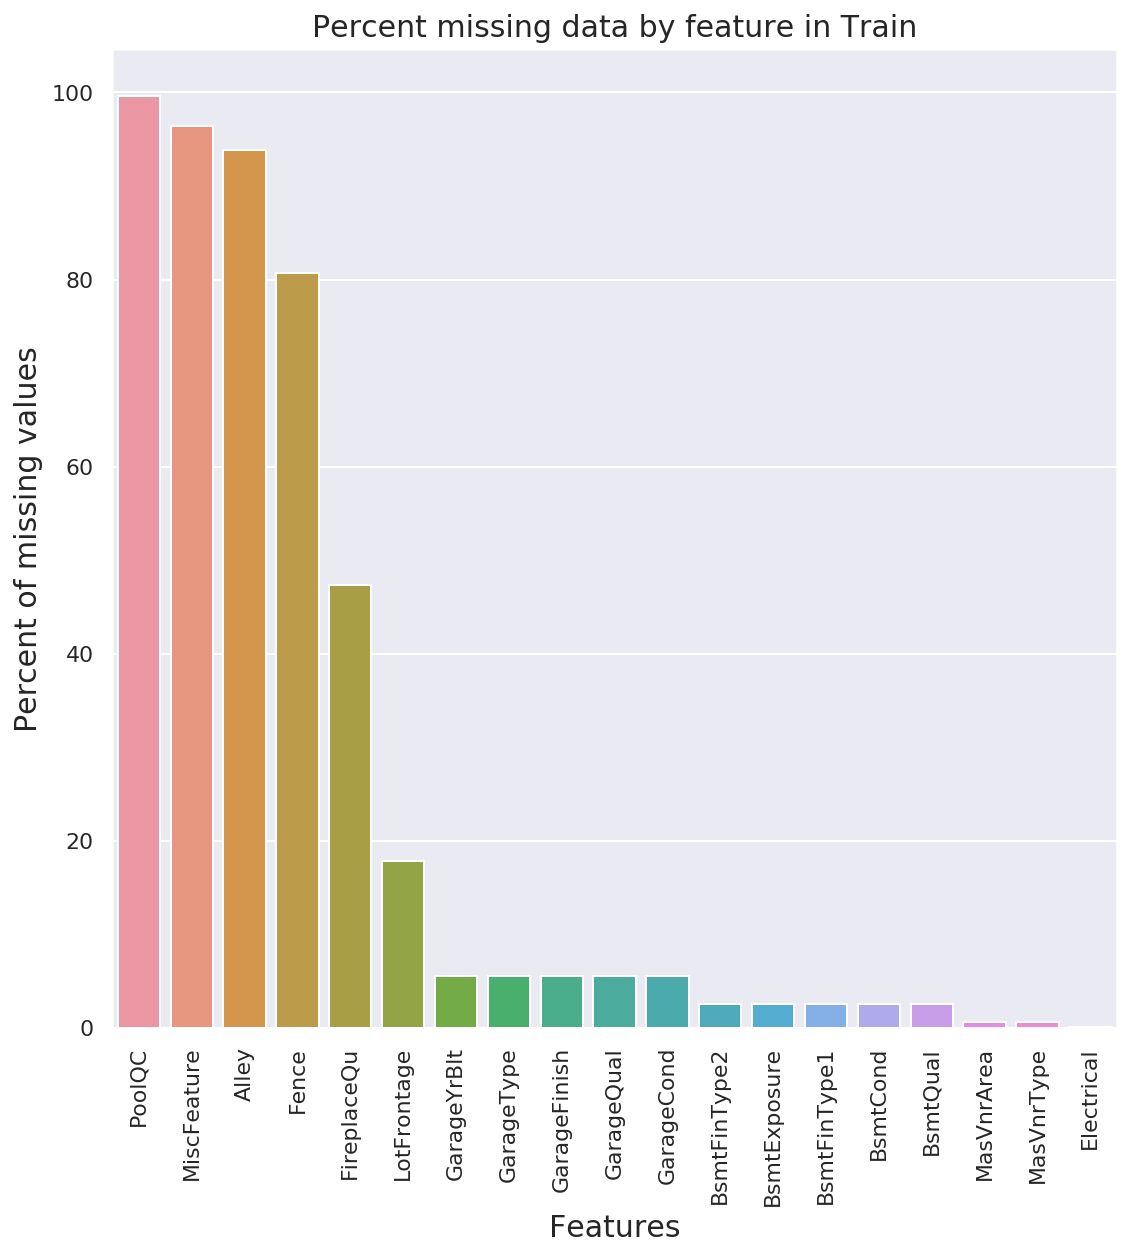

In [50]:
# Percent missing data by feature
f, ax = plt.subplots(figsize = (9, 9))
plt.xticks(rotation = '90')
sns.barplot(x = trainfull_na.index, y = trainfull_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature in Train', fontsize=15)

Text(0.5, 1.0, 'Percent missing data by feature in Test')

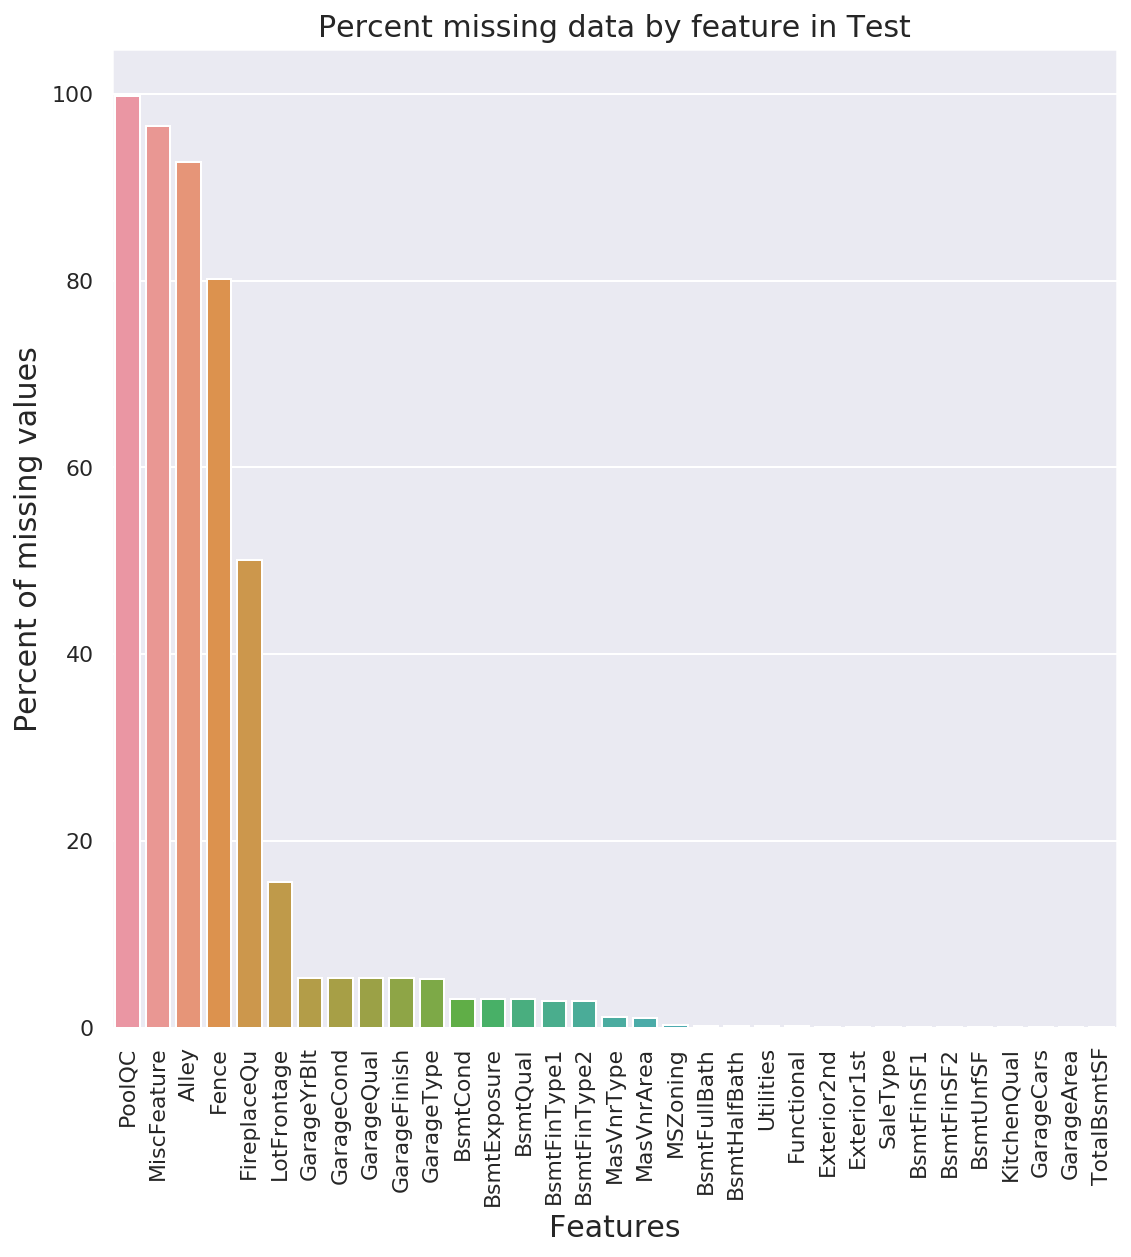

In [51]:
# Percent missing data by feature
f, ax = plt.subplots(figsize = (9, 9))
plt.xticks(rotation = '90')
sns.barplot(x = test_na.index, y = test_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature in Test', fontsize=15)

### Handle Missing Data

With the help of the description file, we can say :

* **PoolQC** : data description says NA means "No Pool"
* **MiscFeature** : data description says NA means "no misc feature"
* **Alley** : data description says NA means "no alley access"
* **Fence** : data description says NA means "no fence"
* **FireplaceQu** : data description says NA means "no fireplace"
* **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
* **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with "None".
* **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0.
* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**: Replacing missing data with 0.
* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there isn't a basement.
* **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
* **MSZoning** (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
* **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
* **Functional** : data description says NA means typical.
* **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
* **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
* **Exterior1st and Exterior2nd **: Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
* **SaleType** : Fill in again with most frequent which is "WD"
* **MSSubClass** : Na most likely means No building class. We can replace missing values with None

Let's do this

In [52]:
datasets = [trainfull, test]
for dataset in datasets:
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'PoolQC', 'MiscFeature', 'MiscFeature', 'Fence',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'MasVnrType', 'MSSubClass', 'Alley'):
        dataset[col] = dataset[col].fillna('None')
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                'MasVnrArea'):
        dataset[col] = dataset[col].fillna(0)
    
    for col in ('MSZoning', 'Electrical', 'KitchenQual',
                'Exterior1st', 'Exterior2nd', 'SaleType'):
        dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
    
    dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    

In [53]:
for dataset in datasets:
    dataset.drop(['Utilities'], axis=1, inplace=True)

In [54]:
for dataset in datasets:
    dataset["Functional"] = dataset["Functional"].fillna("Typ")

In [55]:
trainfull_na = (trainfull.isnull().sum() / len(trainfull)) * 100
trainfull_na = trainfull_na.drop(trainfull_na[trainfull_na == 0].index).sort_values(ascending = False)

In [56]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending = False)

In [57]:
print(f"Number of missing values in trainfull: {len(trainfull_na)}")
print(f"Number of missing values in test: {len(test_na)}")

Number of missing values in trainfull: 0
Number of missing values in test: 0


Now we don't have any missing values

## Data Preprocessing

We have to change some numerical into categorical because they are code more than values.  
For example MSSubClass = 20 is not six times worth than MSSubClass = 120. 

In [58]:
for dataset in datasets:
    dataset['MSSubClass'] = dataset['MSSubClass'].apply(str)
    dataset['OverallCond'] = dataset['OverallCond'].apply(str)
    dataset['YrSold'] = dataset['YrSold'].apply(str)
    dataset['MoSold'] = dataset['MoSold'].apply(str)

For categorical features we use LabelEncoder to give numerical values to these features

In [59]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Process columns and apply LabelEncoder to categorical features
for dataset in datasets:
    for col in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(dataset[col].values)) 
        dataset[col] = lbl.transform(list(dataset[col].values))

    # Check shape
    print('Shape dataset : {}'.format(dataset.shape))

Shape dataset : (1444, 79)
Shape dataset : (1459, 78)


We check if MSSubClass are labelised with success in trainfull

In [60]:
trainfull['MSSubClass'].unique()

array([ 9,  4, 10,  8,  3,  7, 14,  0,  5, 13, 12,  1, 11,  2,  6])

We check if MSSubClass are labelised with success in test

In [61]:
test['MSSubClass'].unique()

array([ 5, 10,  0,  2, 13,  6,  9, 15, 14,  4,  8, 11, 12,  3,  7,  1])

In [62]:
y_trainfull = trainfull['SalePrice'].values
X_trainfull = trainfull.drop('SalePrice', axis=1)

num_features = X_trainfull.dtypes[X_trainfull.dtypes != "object"].index

# Check the skew of all numerical features
skewed_features = X_trainfull[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness' :skewed_features})
skewness.head(20)

,Skewness
MiscVal,29.663183
PoolArea,17.353983
LotArea,12.606620
3SsnPorch,10.235667
LowQualFinSF,9.826264
LandSlope,4.816493
KitchenAbvGr,4.710587
BsmtFinSF2,4.277124
BsmtHalfBath,4.104783
ScreenPorch,4.044379


We fix a threshold for skewness at 0.75

In [63]:
skewness = skewness[abs(skewness) > 0.75]
print(f"There are {skewness.shape[0]} skewed (>0.75) numerical features")

There are 58 skewed (>0.75) numerical features


In [64]:
skewness.index

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'LandSlope', 'KitchenAbvGr', 'BsmtFinSF2', 'BsmtHalfBath',
       'ScreenPorch', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF',
       'LotFrontage', 'WoodDeckSF', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'BsmtFinSF1', 'OverallCond', 'HalfBath', 'Fireplaces',
       'BsmtFullBath', 'TotalBsmtSF', 'TotRmsAbvGrd', 'HeatingQC',
       'FireplaceQu', 'MSSubClass', 'OverallQual', 'BsmtFinType1', 'YrSold',
       'GarageArea', 'FullBath', 'BedroomAbvGr', 'Alley', 'GarageCars',
       'BsmtQual', 'YearRemodAdd', 'LotShape', 'YearBuilt', 'GarageFinish',
       'MoSold', 'BsmtExposure', 'KitchenQual', 'ExterQual', 'Fence',
       'ExterCond', 'BsmtCond', 'BsmtFinType2', 'GarageQual', 'PavedDrive',
       'CentralAir', 'GarageCond', 'GarageYrBlt', 'Functional', 'Street',
       'PoolQC'],
      dtype='object')

We will use the Box-Cox Transformation on the skewed features to get a more normal dist.  
We use scipy's boxcox1p function to do this.  
We will use a value of lambda of 0.15

In [65]:
from scipy.special import boxcox1p
datasets = [X_trainfull, test]
boxcox_features = skewness.index
lam = 0.15
for dataset in datasets:
    for feat in boxcox_features:
        dataset[feat] = boxcox1p(dataset[feat], lam)
        dataset[feat] += 1

In [66]:
skewed_features = X_trainfull[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness' :skewed_features})
skewness.head(20)

,Skewness
PoolArea,16.930756
LowQualFinSF,8.080041
3SsnPorch,7.782727
MiscVal,5.590319
LandSlope,4.352690
KitchenAbvGr,4.162648
BsmtHalfBath,3.947600
ScreenPorch,3.176576
BsmtFinSF2,2.635290
EnclosedPorch,2.157667


The skewness values are now lower.

### Creating dummy variables

The model we shall use accept only numbers so we have to transform strings values into numbers.  
We create dummy variable for our categorical features.  
We use pandas get_dummies method for this.

In [65]:
print(f"X_trainfull shape: {X_trainfull.shape}")
print(f"test shape: {test.shape}")

X_trainfull shape: (1444, 78)
test shape: (1459, 78)


In [66]:
#for dataset in datasets:
X_trainfull = pd.get_dummies(X_trainfull)
test = pd.get_dummies(test)

After using get_dummies, we observe that test dataframe has 13 missing columns compared to X_trainfull

In [67]:
print(f"X_trainfull shape: {X_trainfull.shape}")
print(f"test shape: {test.shape}")

X_trainfull shape: (1444, 217)
test shape: (1459, 205)


What columns are missing?

In [68]:
missing_train_cols = pd.DataFrame(columns = [feature for feature in test.columns if feature not in X_trainfull.columns])
missing_train_cols.columns

Index([], dtype='object')

In [69]:
missing_test_cols = pd.DataFrame(columns = [feature for feature in X_trainfull.columns if feature not in test.columns])
missing_test_cols.columns

Index(['Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other',
       'Heating_Floor', 'Heating_OthW', 'Electrical_Mix'],
      dtype='object')

We concatenate test and missing_test_cols dataframes, fill these columns with zeros and reorder columns based on X_train columns.  
Same with X_trainfull and missing_train_cols

In [70]:
test = pd.concat([test,missing_test_cols], axis=1)

In [71]:
test = test.fillna(0)

In [72]:
X_trainfull = pd.concat([X_trainfull, missing_train_cols], axis=1)

In [73]:
X_trainfull = X_trainfull.fillna(0)

In [74]:
test = test[list(X_trainfull.columns)]

In [75]:
test.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5,80.0,11622,1,1,3,0,5,5,1961,...,0,0,0,1,0,0,0,0,1,0
1,5,81.0,14267,1,1,0,0,6,5,1958,...,0,0,0,1,0,0,0,0,1,0
2,10,74.0,13830,1,1,0,0,5,4,1997,...,0,0,0,1,0,0,0,0,1,0
3,10,78.0,9978,1,1,0,0,6,5,1998,...,0,0,0,1,0,0,0,0,1,0
4,0,43.0,5005,1,1,0,0,8,4,1992,...,0,0,0,1,0,0,0,0,1,0


In [76]:
X_trainfull.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,9,65.0,8450,1,1,3,0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,4,80.0,9600,1,1,3,0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,9,68.0,11250,1,1,0,0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,10,60.0,9550,1,1,0,0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,9,84.0,14260,1,1,0,0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


In [77]:
print(f"X_trainfull shape: {X_trainfull.shape}")
print(f"test shape: {test.shape}")

X_trainfull shape: (1444, 217)
test shape: (1459, 217)


## Modeling

 ### Import model

In [78]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb

### Target column

In [79]:
y_train_log

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [80]:
X_trainfull['SalePrice_log'] = y_train_log
trainfull = X_trainfull

In [81]:
trainfull.to_csv('./input/trainfull_prepared.csv', index=False)
test.to_csv('./input/test_prepared.csv', index=False)

### Train-test split

In [82]:
target = "SalePrice_log"

train, val = train_test_split(trainfull, test_size=0.3, random_state=42)

X_train = train.drop(target, axis=1).values
y_train = train[target].values
X_val = val.drop(target, axis=1).values
y_val = val[target].values

X_test = test.values

### Instantiate model class

In [83]:
# XGBRegressor
xgbr = xgb.XGBRegressor(
    min_child_weight= 7, 
    max_depth= 10, 
    learning_rate= 0.15, 
    gamma= 0.1, 
    colsample_bytree= 0.5,
    random_state=42
)

In [84]:
# Kernel Ridge
krr = KernelRidge(alpha=1, 
                  kernel='polynomial', 
                  degree=2, 
                  coef0=2.5
                 )

### Train model with the fit method

In [85]:
#fit the model with train data

xgbr.fit(X_train, y_train)
krr.fit(X_train, y_train)

[15:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KernelRidge(alpha=1, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
            kernel_params=None)

### Predicting and checking the results

#### Predictions

In [86]:
y_pred_xgbr = xgbr.predict(X_val)
mse_xgbr = mean_squared_error(y_val, y_pred_xgbr)
print("MSE XGBR: %.4f" % mse_xgbr)
print("RMSE XGBR: %.4f" % np.sqrt(mse_xgbr))

MSE XGBR: 0.2013
RMSE XGBR: 0.4487


In [87]:
y_pred_krr = krr.predict(X_val)
mse_krr = mean_squared_error(y_val, y_pred_krr)
print("MSE Kernel Ridge: %.4f" % mse_krr)
print("RMSE Kernel Ridge: %.4f" % np.sqrt(mse_krr))

MSE Kernel Ridge: 3.8932
RMSE Kernel Ridge: 1.9731


#### SalePrice real values

In [88]:
y_kaggle_xgbr = np.exp(xgbr.predict(X_test))
y_kaggle_krr = np.exp(krr.predict(X_test))

## Submission

In [89]:
import kaggle

def submit_kaggle(model, y_kaggle, model_name):
    kaggle_feats = {'Id':test_id, 'SalePrice':y_kaggle}
    sub = pd.DataFrame(data=kaggle_feats)
    sub.to_csv('output/submission_{}.csv'.format(model_name), index=False)

    submission_file = 'output/submission_{}.csv'.format(model_name)
    kaggle.api.competition_submit(submission_file, "Submission {}".format(model_name), "house-prices-advanced-regression-techniques")
    

In [90]:
submit_kaggle(krr, y_kaggle_krr, 'krr')

100%|██████████| 33.4k/33.4k [00:03<00:00, 9.19kB/s]


In [93]:
submit_kaggle(xgbr, y_kaggle_xgbr, 'xgbr')

100%|██████████| 21.2k/21.2k [00:03<00:00, 5.81kB/s]
